# Price Prediction - Stage C - agofa (compare to booking)

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [32]:
# Load the dataset
file_path = "./data/agoda/processed_agoda_snapshot_2025-03-09.csv"
df = pd.read_csv(file_path)
df = df.dropna(subset=['review_score'])

## Data Collection and Processing

In [33]:
df['review_score'] = df['review_score'].astype(int)
df['distance_from_center'] = (df['distance_from_center']).fillna(df['distance_from_center'].mean()).astype(int)
df['breakfast_included'] = (df['breakfast_included']).fillna(False).astype(int)

In [34]:
df['snapshot_date'] = pd.to_datetime(df['snapshot_date'], format='%Y-%m-%d')  # Correct format
df['checkin_date'] = df['snapshot_date'] + pd.to_timedelta(df['time_to_travel'], unit='D')  # Add days
df['checkin_day'] = df['checkin_date'].dt.day  # Extract day of the month
df['discounted_price_per_night'] = df['discounted_price'] / df['length_of_stay']
df['discounted_price_per_night'] = df['discounted_price_per_night'].astype(int)

In [35]:
df['is_weekend'] = df['checkin_date'].dt.weekday.apply(lambda x: 1 if x in [1,6,7] else 0) 
df['days_to_end_of_month'] = df['checkin_day'].apply(lambda x: 30 - x)  # Days left to the end of the month

In [36]:
df['name_hash'] = df['name'].map(lambda x: hash(x) % 1000)

In [37]:
# Define Features and Target
X = df[['time_to_travel', 'length_of_stay','review_score', 'distance_from_center','breakfast_included', 'days_to_end_of_month', 'is_weekend','name_hash']]  # Features
y = df['discounted_price_per_night']  # Target Variable

In [38]:
# Split Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [39]:
# Normalize Data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


## 🤖 Model Training & Evaluation

### Regression Algorithms

In [40]:
# Train Multiple Regression Models
models = {
    'Decision Tree depth 10': DecisionTreeRegressor(max_depth=10),
    'Random Forest depth 10': RandomForestRegressor(n_estimators=100, max_depth=10),
}

In [41]:
#Train and Evaluate Models
results = {}
for name, model_copy in models.items():
     print(f'current model: {name}')
     model_copy.fit(X_train_scaled, y_train)
     print(f'done fit: {name}')
     y_pred = model_copy.predict(X_test_scaled)
     results[name] = {
          'R2': r2_score(y_test, y_pred),
          'MAE': mean_absolute_error(y_test, y_pred),
          'MSE': mean_squared_error(y_test, y_pred),
          'RMSE': np.sqrt(mean_squared_error(y_test, y_pred))
     }
     print(f'logged: {name}')

current model: Decision Tree depth 10
done fit: Decision Tree depth 10
logged: Decision Tree depth 10
current model: Random Forest depth 10
done fit: Random Forest depth 10
logged: Random Forest depth 10


In [42]:
# Convert Results to DataFrame
results_df = pd.DataFrame(results).T
print(results_df)

                               R2        MAE            MSE        RMSE
Decision Tree depth 10 -14.817423  40.703234  301853.589716  549.412040
Random Forest depth 10  -1.589997  36.225505   49426.508134  222.320733


The results of the Agoda and Booking price prediction models highlight significant differences in performance across various machine learning algorithms. For Agoda, the Decision Tree model with depth 10 performed poorly, with an extremely negative 
𝑅
2
R 
2
  value (-14.82) and a high RMSE (549.41), indicating severe overfitting or data inconsistencies. In contrast, the Random Forest with depth 10 performed much better, with a notably lower RMSE (222.32). For Booking, the best-performing model was the Random Forest with depth 10, achieving the highest 
𝑅
2
R 
2
  (0.6546) and the lowest RMSE (43.05), suggesting strong predictive capabilities. Decision Trees and Gradient Boosting also showed promising results, particularly with deeper trees and higher learning rates. Linear Regression and SVR models underperformed, with relatively high RMSE values, indicating their limited effectiveness for this task. Overall, ensemble methods like Random Forest and Gradient Boosting demonstrated the best balance between accuracy and error minimization for predicting hotel prices.

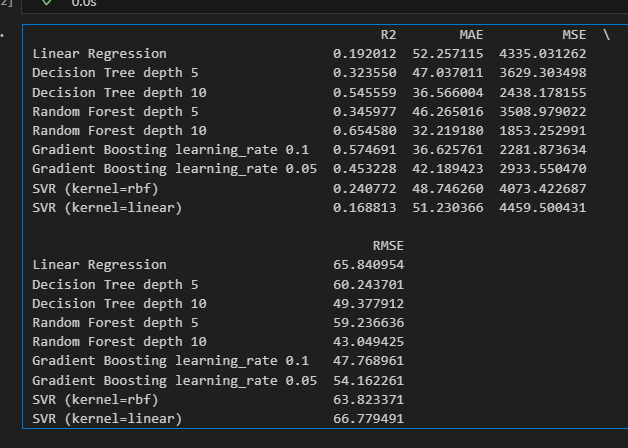

### Neural Networks

In [43]:
# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

# Create data loaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Neural Network Model 1
class NeuralNet1(nn.Module):
    def __init__(self, input_dim):
        super(NeuralNet1, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)
        
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

def train_model(model, train_loader, test_loader, epochs=50):
    criterion = nn.SmoothL1Loss()
    optimizer = optim.Adam(model.parameters(), lr=0.0003, weight_decay=1e-4)
    
    for epoch in range(epochs):
        model.train()
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            loss.backward()
            optimizer.step()
        
        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for X_batch, y_batch in test_loader:
                y_pred = model(X_batch)
                val_loss += criterion(y_pred, y_batch).item()
        val_loss /= len(test_loader)
        print(f"Epoch {epoch+1}/{epochs}, Validation Loss: {val_loss:.4f}")

# Train NeuralNet1
model1 = NeuralNet1(X_train_scaled.shape[1])
train_model(model1, train_loader, test_loader)

Epoch 1/50, Validation Loss: 48.4664
Epoch 2/50, Validation Loss: 42.2714
Epoch 3/50, Validation Loss: 40.9661
Epoch 4/50, Validation Loss: 39.9767
Epoch 5/50, Validation Loss: 39.3576
Epoch 6/50, Validation Loss: 38.9368
Epoch 7/50, Validation Loss: 38.6607
Epoch 8/50, Validation Loss: 38.4415
Epoch 9/50, Validation Loss: 38.2131
Epoch 10/50, Validation Loss: 38.0317
Epoch 11/50, Validation Loss: 37.8382
Epoch 12/50, Validation Loss: 37.6357
Epoch 13/50, Validation Loss: 37.4584
Epoch 14/50, Validation Loss: 37.3103
Epoch 15/50, Validation Loss: 37.1544
Epoch 16/50, Validation Loss: 37.1659
Epoch 17/50, Validation Loss: 36.8517
Epoch 18/50, Validation Loss: 36.7279
Epoch 19/50, Validation Loss: 36.6409
Epoch 20/50, Validation Loss: 36.5333
Epoch 21/50, Validation Loss: 36.4378
Epoch 22/50, Validation Loss: 36.3287
Epoch 23/50, Validation Loss: 36.2873
Epoch 24/50, Validation Loss: 36.1938
Epoch 25/50, Validation Loss: 36.2029
Epoch 26/50, Validation Loss: 36.0652
Epoch 27/50, Validati

In [44]:
def evaluate_model(model, X_test, y_test):
    model.eval()
    with torch.no_grad():
        y_pred = model(X_test).numpy()
    
    # Scatter plot: Predictions vs Actual
    plt.figure()
    plt.scatter(y_test.numpy(), y_pred, alpha=0.5, color='blue')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title('Actual vs Predicted')
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r')  # Identity line
    plt.show()

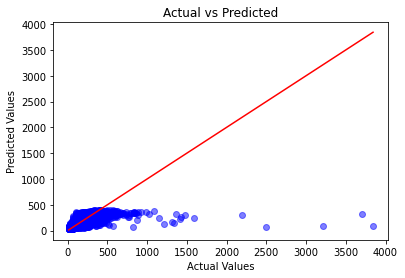

In [45]:
evaluate_model(model1, X_test_tensor, y_test_tensor)

although the plot of booking (the one right under me) may seem better, we can see that the loss value of the prediction in agoda hotels is lower and brought us to a better position predicting the price

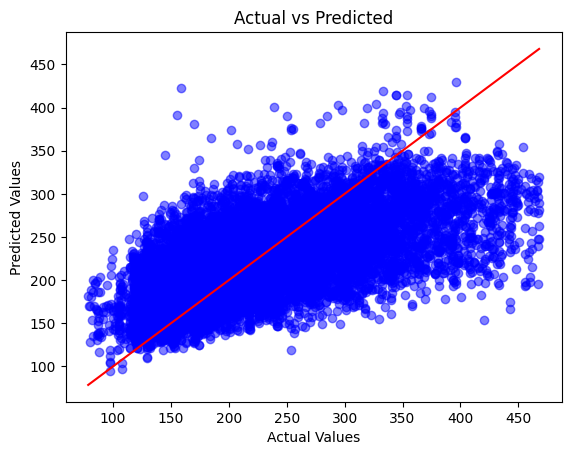

### Rank Feature Imprtance

In [46]:
def display_feature_importance(model_name):
    model_copy = models[model_name]
    importance = model_copy.feature_importances_
    
    plt.figure(figsize=(10, 4))
    sns.barplot(x=X.columns, y=importance)
    plt.title(f'Feature Importance - {model_name}')
    plt.xticks(rotation=45)
    plt.show()

In [47]:
def display_permutation_importance(model_name):
    model_copy = models[model_name]
    result = permutation_importance(model_copy, X_test_scaled, y_test, n_repeats=10, random_state=42)
    importance = result.importances_mean

    plt.figure(figsize=(10, 4))
    sns.barplot(x=X.columns, y=importance)
    plt.title(f'Permutation Feature Importance - {model_name}')
    plt.xticks(rotation=45)
    plt.show()

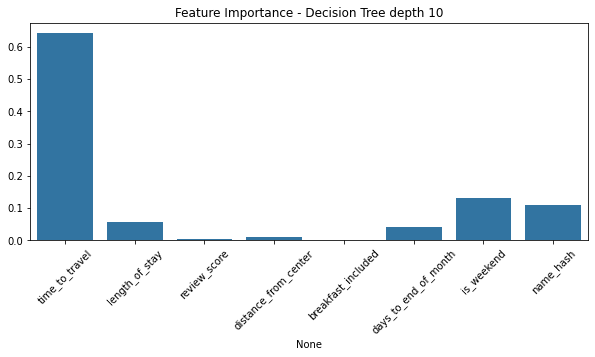

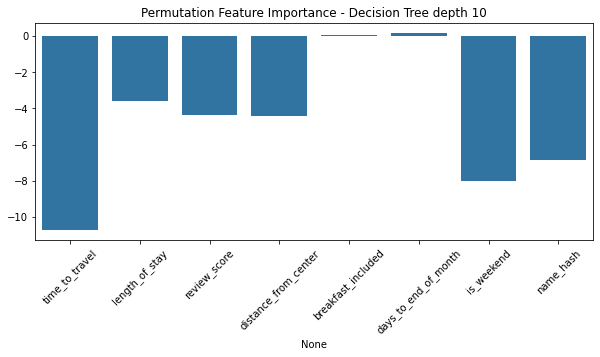

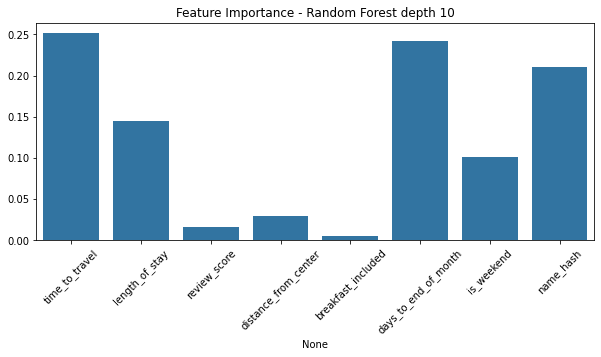

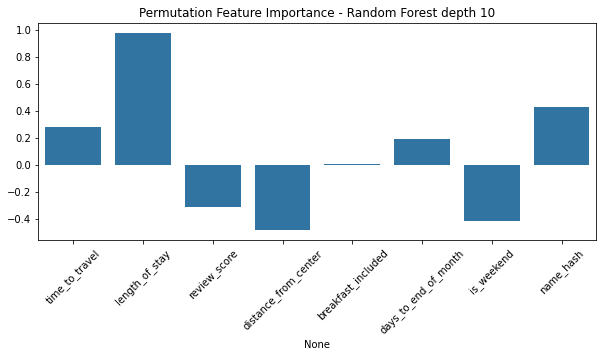

In [48]:
models_to_visualize_feature_impotrence = ['Decision Tree depth 10','Random Forest depth 10']
display_feature_importance(models_to_visualize_feature_impotrence[0])
display_permutation_importance(models_to_visualize_feature_impotrence[0])
display_feature_importance(models_to_visualize_feature_impotrence[1])
display_permutation_importance(models_to_visualize_feature_impotrence[1])

Booking:

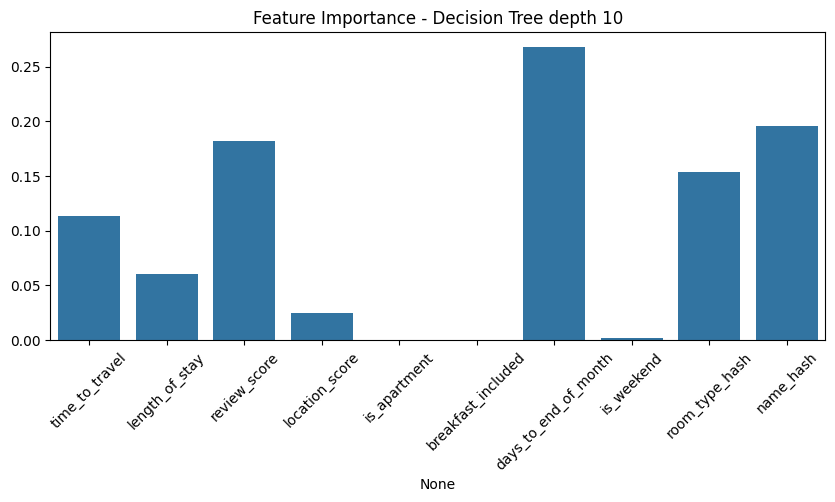

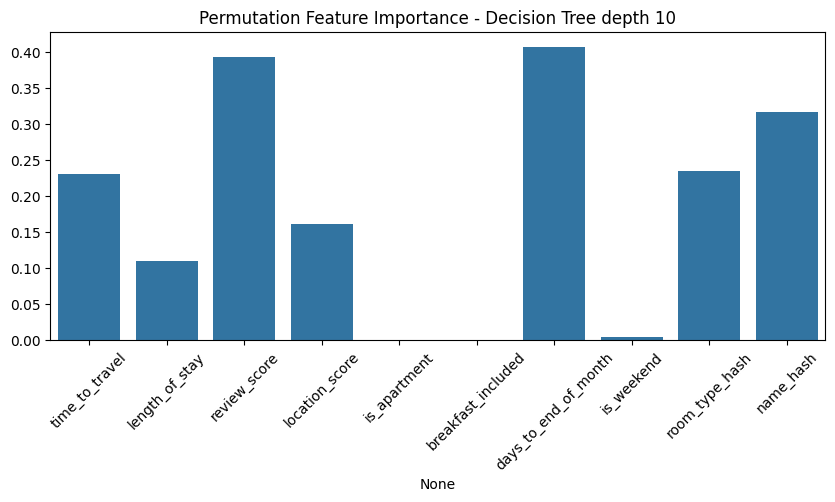

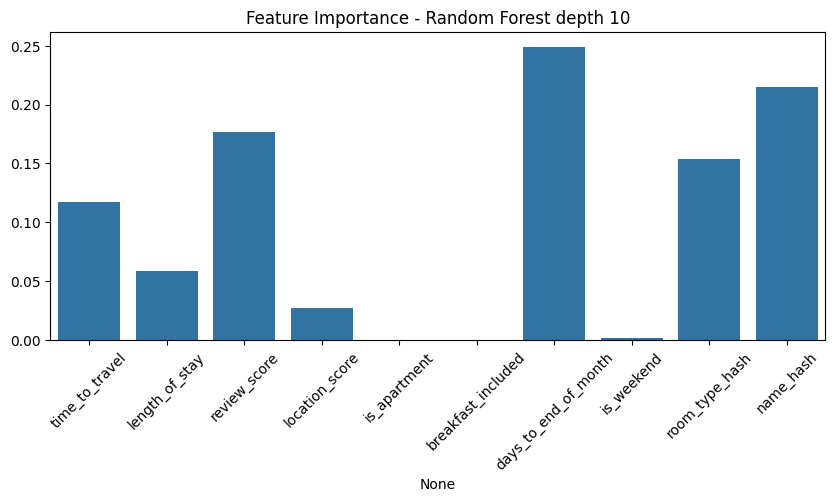

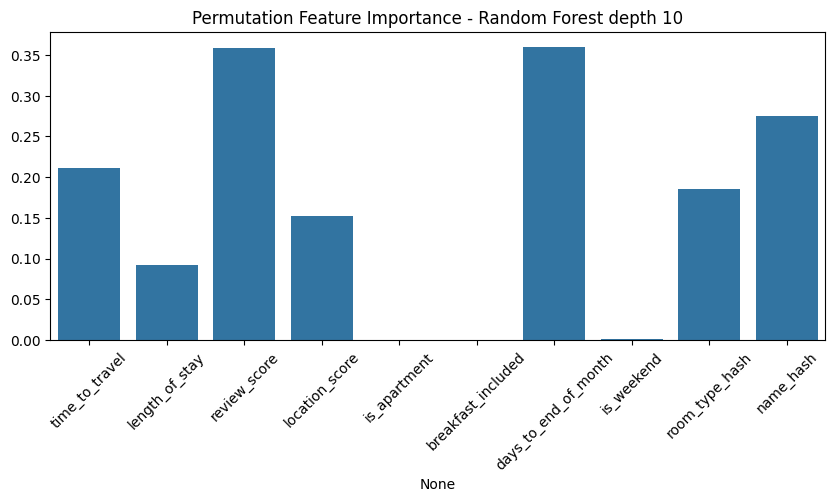